In [1]:
from qiskit import *
import numpy as np
import pylab as pl

Import qiskit utilities (assumes you have cloned it into a folder in the ../ directory)

In [2]:
import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

Import functions for error mitigation using zero noise extrapolation

In [3]:
from zero_noise_extrapolation import *

Define a function creating the 5qubit GHZ state circuit and plot it

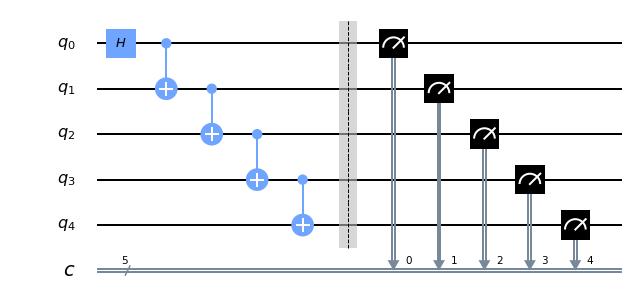

In [4]:
def get_circuit(usebarrier=False, measure=True, applynotpos=-1):
    circ = "OPENQASM 2.0;\ninclude \"qelib1.inc\";\
    qreg q[5];\
    creg c[5];"
    if applynotpos>-1 and applynotpos<5:
        circ = circ + "x q["+str(applynotpos)+"];"
    circ = circ + "h q[0];\
    cx q[0],q[1];\
    cx q[1],q[2];\
    cx q[2],q[3];\
    cx q[3],q[4];"
    if usebarrier:
        circ = circ + "barrier q[0],q[1],q[2],q[3],q[4]; "
    if measure:
        circ = circ + 'measure q[0] -> c[0];\
        measure q[1] -> c[1];\
        measure q[2] -> c[2];\
        measure q[3] -> c[3];\
        measure q[4] -> c[4];'
    qc = QuantumCircuit.from_qasm_str(circ)
    return qc


get_circuit(True).draw(output='mpl')

Create dictionaries for backends, noisemodels, basis gates and cx error maps

In [5]:
backends_dict={}
noisemodels_dict={}
basis_gates_dict={}
cx_error_maps_dict={}

Populate backends with 1) local simulator, 2) IBM's QX2 device, 3) IBM's Ourense device

In [6]:
backendname_sim = 'qasm_simulator'
backends_dict[backendname_sim] = Aer.get_backend(backendname_sim)

#load IBMQ account
#IBMQ.save_account('yourAPItoken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backendname_x2 = 'ibmqx2'
backendname_ourense = 'ibmq_ourense'

for backendname in [backendname_x2, backendname_ourense]:
    backends_dict[backendname] = provider.get_backend(backendname)

For the simulator, create noise models, cx error maps, basis gates for IBM's QX2, and Ourense device

In [7]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model

for backendname in [backendname_x2, backendname_ourense]:
    backend = backends_dict[backendname]

    noisemodels_dict[backendname] = basic_device_noise_model(backend.properties())
    cx_error_maps_dict[backendname] = get_cx_error_map(backend)
    basis_gates_dict[backendname] = noisemodels_dict[backendname].basis_gates

noisemodels_dict['None'] = None

define a function for the expectation value

In [8]:
numones=np.zeros((2**5,1))
for i in range(2**5):
    numones[i]=bin(i).count("1")

In [9]:
def expectationValue(results, myfilter=None):
    #num_qubits = results[0].header.n_qubits
    E=np.zeros((len(results),1))
    if myfilter==None:
        for item in range(0,len(results)):
            shots = results[item].shots
            counts = results[item].data.counts
            for key in list(counts.__dict__.keys()):
                c=getattr(counts, key)#number of counts
                E[item] += numones[int(key,0)]*c/shots
    else:
        binres=convert_to_binarystring(results)
        for item in range(0,len(results)):
            binresfilt=myfilter.apply(binres[item])
            shots = results[item].shots
            for key in binresfilt:
                E[item] += numones[int(str(key),2)]*binresfilt[key]/shots
    return E

Mitigate the result of the simulator with a noise model

In [10]:
R,E_dict,E_av_dict,\
max_depth_dict,mean_depth_dict,\
max_depth_transpiled_dict,mean_depth_transpiled_dict,\
bn=\
mitigate(get_circuit(), [1,2,4,8,16,32],\
             expectationValue,\
             backends_dict[backendname_sim], \
             "GHZ", cx_error_maps_dict[backendname_x2],\
             8192, 1024,\
             backends_dict[backendname_x2],\
             noisemodels_dict[backendname_x2],\
             basis_gates_dict[backendname_x2],\
             )
print("Expectation value without error mitigation E = ",E_av_dict[bn+"_r1"][-1][0])
print("Expectation value with error mitigation E = ",R[-1][0])

Sanity checks passed
Result for job ' GHZ_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r1 ' successfully read from disk
Result for job ' GHZ_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r2 ' successfully read from disk
Result for job ' GHZ_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r4 ' successfully read from disk
Result for job ' GHZ_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r8 ' successfully read from disk
Result for job ' GHZ_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r16 ' successfully read from disk
Result for job ' GHZ_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r32 ' successfully read from disk
Expectation value without error mitigation E =  2.4676350355148315
Expectation value with error mitigation E =  2.468638862821302


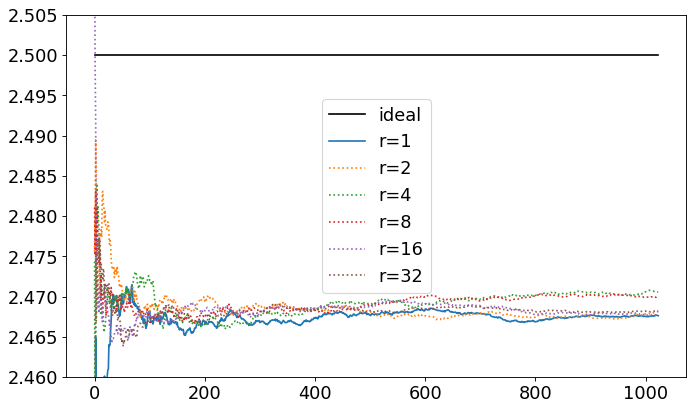

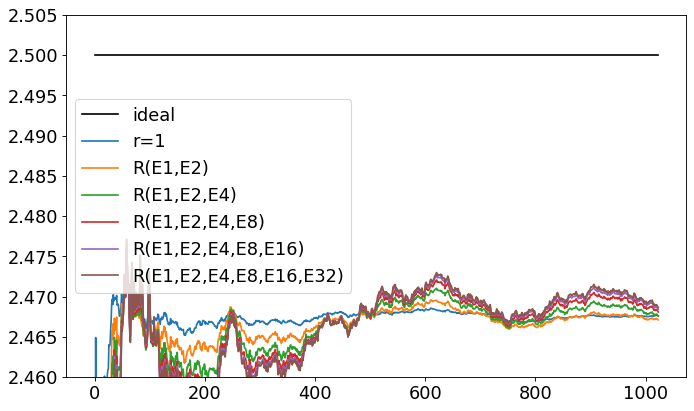

In [11]:
font = {'size' : 16}
pl.matplotlib.rc('font', **font);
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(2.5+0*E_av_dict[bn+"_r1"],'k',label='ideal')
pl.plot(E_av_dict[bn+"_r1"],label='r=1')
pl.plot(E_av_dict[bn+"_r2"],':',label='r=2')
pl.plot(E_av_dict[bn+"_r4"],':',label='r=4')
pl.plot(E_av_dict[bn+"_r8"],':',label='r=8')
pl.plot(E_av_dict[bn+"_r16"],':',label='r=16')
pl.plot(E_av_dict[bn+"_r32"],':',label='r=32')
pl.ylim(2.46,2.505)
pl.legend();

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(2.5+0*E_av_dict[bn+"_r1"],'k',label='ideal')
pl.plot(E_av_dict[bn+"_r1"],label='r=1')

R12=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"]]),\
                           np.array([1,2]))
pl.plot(R12[0],label='R(E1,E2)')

R124=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"],\
                                     E_av_dict[bn+"_r4"]]),\
                           np.array([1,2,4]))
pl.plot(R124[0],label='R(E1,E2,E4)')

R1248=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"],\
                                     E_av_dict[bn+"_r4"],\
                                     E_av_dict[bn+"_r8"]]),\
                           np.array([1,2,4,8]))
pl.plot(R1248[0],label='R(E1,E2,E4,E8)')

R124816=Richardson_extrapolate(np.array([E_av_dict[bn+"_r1"],\
                                     E_av_dict[bn+"_r2"],\
                                     E_av_dict[bn+"_r4"],\
                                     E_av_dict[bn+"_r8"],\
                                     E_av_dict[bn+"_r16"]]),\
                           np.array([1,2,4,8,16]))
pl.plot(R124816[0],label='R(E1,E2,E4,E8,E16)')

pl.plot(R,label='R(E1,E2,E4,E8,E16,E32)')
pl.ylim(2.46,2.505)
pl.legend();

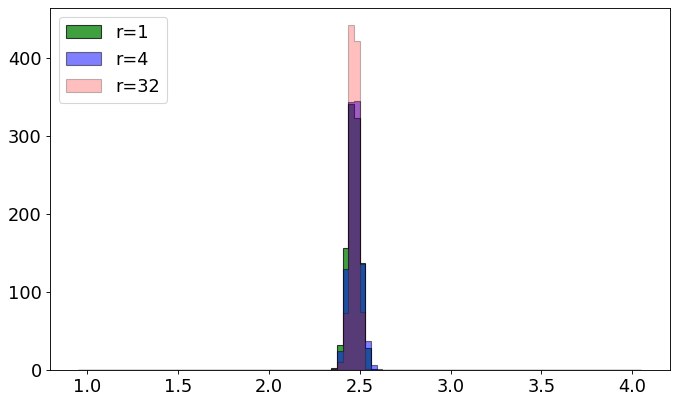

In [12]:
xmin=0.95
numbins=100
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
d=pl.hist(E_dict[bn+"_r1"],edgecolor = 'black',color='green',range=(xmin,4.05),bins=numbins,\
                 alpha=.75,histtype='stepfilled',label='r=1')
d=pl.hist(E_dict[bn+"_r4"],edgecolor = 'black',color='blue',range=(xmin,4.05),bins=numbins,\
                 alpha=0.5,histtype='stepfilled',label='r=4')
d=pl.hist(E_dict[bn+"_r32"],edgecolor = 'black',color='red',range=(xmin,4.05),bins=numbins,\
                 alpha=0.25,histtype='stepfilled',label='r=32')
pl.legend(loc='upper left');

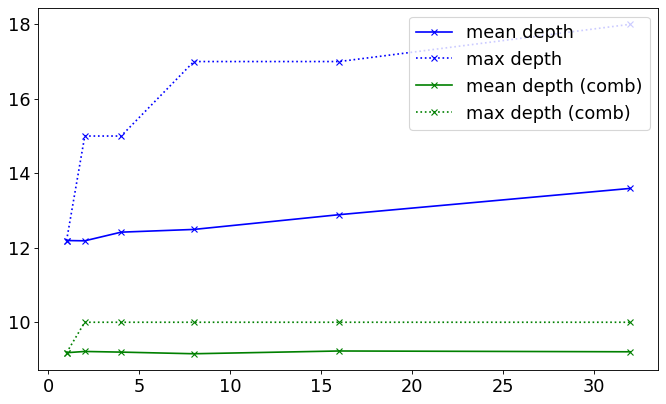

In [13]:
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_dict[bn+"_r1"],\
        mean_depth_dict[bn+"_r2"],\
        mean_depth_dict[bn+"_r4"],\
        mean_depth_dict[bn+"_r8"],\
        mean_depth_dict[bn+"_r16"],\
        mean_depth_dict[bn+"_r32"]),'bx-',label='mean depth')
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_dict[bn+"_r1"],\
        max_depth_dict[bn+"_r2"],\
        max_depth_dict[bn+"_r4"],\
        max_depth_dict[bn+"_r8"],\
        max_depth_dict[bn+"_r16"],\
        max_depth_dict[bn+"_r32"]),'bx:',label='max depth')
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_transpiled_dict[bn+"_r1"],\
        mean_depth_transpiled_dict[bn+"_r2"],\
        mean_depth_transpiled_dict[bn+"_r4"],\
        mean_depth_transpiled_dict[bn+"_r8"],\
        mean_depth_transpiled_dict[bn+"_r16"],\
        mean_depth_transpiled_dict[bn+"_r32"]),'gx-',label='mean depth (comb)')
pl.plot(np.array([1,2,4,8,16,32]),(mean_depth_transpiled_dict[bn+"_r1"],\
        max_depth_transpiled_dict[bn+"_r2"],\
        max_depth_transpiled_dict[bn+"_r4"],\
        max_depth_transpiled_dict[bn+"_r8"],\
        max_depth_transpiled_dict[bn+"_r16"],\
        max_depth_transpiled_dict[bn+"_r32"]),'gx:',label='max depth (comb)')
pl.legend();